# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [ ]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [ ]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')

!fusermount -u drive
!google-drive-ocamlfuse drive


drive.mount("/content/drive", force_remount=True)


/bin/bash: google-drive-ocamlfuse: command not found
Mounted at /content/drive


In [ ]:

%cd '/content/drive/MyDrive/Colab Notebooks/Assignment1'

In [ ]:
!pwd
!nvidia-smi

/content/drive/MyDrive/Colab Notebooks/Assignment1
Sat Oct  1 15:16:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                     

# Read Data

##Importing data

In [ ]:
df = pd.read_csv('full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [ ]:
df['label'] = df['filename'].str.split('_').str[-2]

In [ ]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [ ]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

##Question 1


Design a feedforward deep neural network (DNN) which consists of an input layer, three hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function.

Use a mini-batch gradient descent with ‘adam’ optimizer with learning rate of 0.001, and batch size = 256. 

Apply dropout of probability 0.2 to each of the hidden layers.

Divide the dataset into a 70:30 ratio for training and testing. Use appropriate scaling of input features. We solely assume that there are only two datasets here: training & test. We would look into validation in Question 2 onwards. (Note that we make the simplifying assumption here that each data sample is independent, hence a random split is performed.)


In [ ]:
# define the 77-128-128-128-1 architecture using Keras
model = Sequential()

# With respect to the number of neurons comprising this layer, this parameter is 
# completely and uniquely determined once you know the shape of your training data. 
# Specifically, the number of neurons comprising that layer is equal to the number 
# of features (columns) in your data. Some NN configurations add one additional 
# node for a bias term.
model.add(Dense(77, input_shape=(77,), activation="relu"))

# three hidden layers of 128 neurons each with ReLU activation function
# Apply dropout of probability 0.2 to each of the hidden layers.
for i in range(3):
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

# an output layer with sigmoid activation function.
model.add(Dense(1, activation="sigmoid"))


# Use a mini-batch gradient descent with ‘adam’ optimizer with learning rate of 0.001, and batch size = 256. 
opt = keras.optimizers.Adam(learning_rate=0.001)

# Binary crossentropy is a loss function that is used in binary classification tasks.
# These are tasks that answer a question with only two choices (yes or no, A or B, 0 or 1, left or right).
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# a) Use the training dataset to train the model for 100 epochs. Implement early stopping with patience of 3.

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)


H = model.fit(X_train_scaled, 
              y_train, epochs=100, 
              batch_size=256,
              use_multiprocessing=True,
              callbacks=[callback],
              validation_data=(X_test_scaled, y_test),
              verbose = 2)

Epoch 1/100
499/499 - 3s - loss: 0.6883 - accuracy: 0.5382 - val_loss: 0.6835 - val_accuracy: 0.5530 - 3s/epoch - 7ms/step
Epoch 2/100
499/499 - 2s - loss: 0.6816 - accuracy: 0.5583 - val_loss: 0.6806 - val_accuracy: 0.5583 - 2s/epoch - 4ms/step
Epoch 3/100
499/499 - 2s - loss: 0.6767 - accuracy: 0.5657 - val_loss: 0.6772 - val_accuracy: 0.5673 - 2s/epoch - 4ms/step
Epoch 4/100
499/499 - 2s - loss: 0.6712 - accuracy: 0.5791 - val_loss: 0.6723 - val_accuracy: 0.5748 - 2s/epoch - 3ms/step
Epoch 5/100
499/499 - 2s - loss: 0.6647 - accuracy: 0.5887 - val_loss: 0.6676 - val_accuracy: 0.5833 - 2s/epoch - 4ms/step
Epoch 6/100
499/499 - 2s - loss: 0.6572 - accuracy: 0.6005 - val_loss: 0.6643 - val_accuracy: 0.5874 - 2s/epoch - 3ms/step
Epoch 7/100
499/499 - 2s - loss: 0.6502 - accuracy: 0.6111 - val_loss: 0.6568 - val_accuracy: 0.6008 - 2s/epoch - 4ms/step
Epoch 8/100
499/499 - 2s - loss: 0.6429 - accuracy: 0.6202 - val_loss: 0.6527 - val_accuracy: 0.6030 - 2s/epoch - 3ms/step
Epoch 9/100
499/

In [ ]:
# from sklearn.metrics import classification_report

# evaluate the network
print("[INFO] evaluating network...")
# predictions = model.predict(X_test_scaled,validation_data=(X_test_scaled, y_test), batch_size=128)


[INFO] evaluating network...


b) Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots. Explain the use of early stopping in this question.


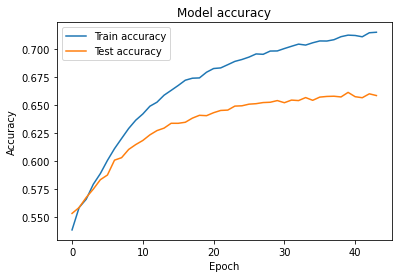

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')
plt.savefig('Q1(b)accuracy.png')

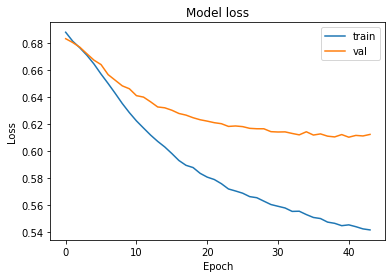

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('Q1(b)loss.png')

Comments:

Early stopping, implemented with the given parameters, is used to terminate the training once the model shows no improvement (defined by decreasing loss) over 3 (defined by patience) epochs.

It used to avoid overfitting when training a learner with an iterative method, ie gradient descent.




##Question 2

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection.

You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
batch_size = [128, 256, 512, 1024]


acc_and_loss_by_batch_size ={}

for BATCH_SIZE in batch_size:
  fold_no = 1

  # Define per-fold score containers <-- these are new
  acc_per_fold = []
  loss_per_fold = []
  time_per_fold = []

  num_folds = 5

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Merge inputs and targets
  inputs = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
  targets = np.concatenate((y_train, y_test), axis=0)

  for train, test in kfold.split(inputs, targets):

    ################### model code #################


    # define the 77-128-128-128-1 architecture using Keras
    model = Sequential()

    # input layer
    model.add(Dense(77, input_shape=(77,), activation="relu"))

    # three hidden layers of 128 neurons each with ReLU activation function
    # Apply dropout of probability 0.2 to each of the hidden layers.
    for i in range(3):
      model.add(Dense(128, activation="relu"))
      model.add(Dropout(0.2))

    # an output layer with sigmoid activation function.
    model.add(Dense(1, activation="sigmoid"))

    # Use a mini-batch gradient descent with ‘adam’ optimizer with learning rate of 0.001, and batch size = 256. 
    opt = keras.optimizers.Adam(learning_rate=0.001)

    # Binary crossentropy is a loss function that is used in binary classification tasks.
    # These are tasks that answer a question with only two choices (yes or no, A or B, 0 or 1, left or right).
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')


    time_callback = TimeHistory()


    H = model.fit(inputs[train], 
                  targets[train], epochs=100, 
                  batch_size=BATCH_SIZE,
                  use_multiprocessing=True,
                  callbacks=[time_callback],
                  validation_data=(inputs[test], targets[test]),
                  verbose = 0)
    
    # Generate generalization metrics
    times = time_callback.times
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f"Batch Size: {BATCH_SIZE}")
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print(f'Time for fold {fold_no}: {times[-1]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    time_per_fold.append(times)

    # Increase fold number
    fold_no = fold_no + 1

  acc_and_loss_by_batch_size[BATCH_SIZE] = {"ACC":acc_per_fold,
                                            "LOSS":loss_per_fold,
                                            "TIME":time_per_fold
                                            }



------------------------------------------------------------------------
Training for fold 1 ...
Batch Size: 128
Score for fold 1: loss of 0.597022294998169; accuracy of 67.77043342590332%
Time for fold 1: 3.5419740676879883
------------------------------------------------------------------------
Training for fold 2 ...
Batch Size: 128
Score for fold 2: loss of 0.5967473983764648; accuracy of 67.50706434249878%
Time for fold 2: 3.593564033508301
------------------------------------------------------------------------
Training for fold 3 ...
Batch Size: 128
Score for fold 3: loss of 0.5906068086624146; accuracy of 67.42202043533325%
Time for fold 3: 3.6236588954925537
------------------------------------------------------------------------
Training for fold 4 ...
Batch Size: 128
Score for fold 4: loss of 0.5941161513328552; accuracy of 67.84998774528503%
Time for fold 4: 3.6764519214630127
------------------------------------------------------------------------
Training for fold 5 ...
B

a) Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. This might take a while to run.

In [ ]:
batch_sizes_to_plt = []
mean_accuracies_to_plt =[]

for batch_sizes, data in acc_and_loss_by_batch_size.items():
  batch_size_acc = data["ACC"]
  mean_fold_acc = sum(batch_size_acc)/len(batch_size_acc)

  batch_sizes_to_plt.append(batch_sizes)
  mean_accuracies_to_plt.append(mean_fold_acc)




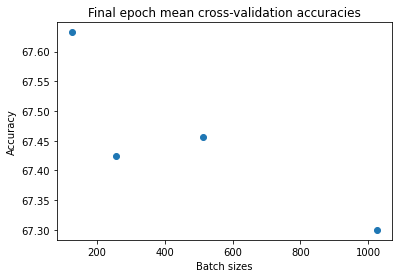

In [ ]:

plt.scatter(batch_sizes_to_plt,mean_accuracies_to_plt)
plt.title('Final epoch mean cross-validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Batch sizes')
# plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')

plt.savefig('Q2(a)mean cross-validation accuracies.png')

b) Create a table of time taken to train the network on the last epoch against
different batch sizes. (Hint: Introduce a callback)

In [ ]:
batch_size_fold = []
time_taken_final_epoch =[]

for batch_sizes, data in acc_and_loss_by_batch_size.items():
  time_taken_per_batch = data["TIME"]
  i =1
  for time_taken in time_taken_per_batch:
    batch_size_fold.append(f"Batch_size_{batch_sizes}_fold_{i}")
    time_taken_final_epoch.append(time_taken[-1])
    i+=1




In [ ]:
d = {'batch_size_fold':batch_size_fold , 'time_taken_final_epoch': time_taken_final_epoch}

df = pd.DataFrame(data=d)

df

,batch_size_fold,time_taken_final_epoch
0,Batch_size_128_fold_1,3.541974
1,Batch_size_128_fold_2,3.593564
2,Batch_size_128_fold_3,3.623659
3,Batch_size_128_fold_4,3.676452
4,Batch_size_128_fold_5,3.413967
5,Batch_size_256_fold_1,1.802147
6,Batch_size_256_fold_2,2.115012
7,Batch_size_256_fold_3,1.781342
8,Batch_size_256_fold_4,1.784759
9,Batch_size_256_fold_5,1.740328


c) Select the optimal batch size and state a reason for your selection.

Answer:

Optimal batch size seems to be 512, as it has the highest mean cross validation accuracy for all compared batch sizes

d) What happens when batch size increases, and why does it happen?

Answer:

Training time per epoch decreases. This is as an epoch is 1 forward and backward propogation of the train dataset.

Batch size constrains the number of data points that can be propagated throught the network at one time. Hence more interation are required when batch size is reduced.

However this is contingent on there being sufficent resouces, usually, this is the gpu memory buffer. For maximum resource allocation, the largest batch size that the gpu memory buffer can accomodate is usually prefered. This would allow for the greatest parallelism as described by Gustafson's law.




e) Plot the train and test accuracies against epochs for the optimal batch size in a line plot.

In [ ]:
BATCH_SIZE = 512
HIDDEN_LAYER_SIZE = 128

# define the 77-128-128-128-1 architecture using Keras
model = Sequential()

model.add(Dense(77, input_shape=(77,), activation="relu"))

for i in range(3):
  model.add(Dense(HIDDEN_LAYER_SIZE, activation="relu"))
  model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


H = model.fit(X_train_scaled, 
              y_train, epochs=100, 
              batch_size=BATCH_SIZE,
              use_multiprocessing=True,
              validation_data=(X_test_scaled, y_test),
              verbose = 2)

Epoch 1/100
250/250 - 2s - loss: 0.6900 - accuracy: 0.5354 - val_loss: 0.6854 - val_accuracy: 0.5468 - 2s/epoch - 8ms/step
Epoch 2/100
250/250 - 1s - loss: 0.6836 - accuracy: 0.5517 - val_loss: 0.6812 - val_accuracy: 0.5569 - 1s/epoch - 4ms/step
Epoch 3/100
250/250 - 1s - loss: 0.6790 - accuracy: 0.5632 - val_loss: 0.6791 - val_accuracy: 0.5622 - 939ms/epoch - 4ms/step
Epoch 4/100
250/250 - 1s - loss: 0.6741 - accuracy: 0.5741 - val_loss: 0.6737 - val_accuracy: 0.5722 - 934ms/epoch - 4ms/step
Epoch 5/100
250/250 - 1s - loss: 0.6688 - accuracy: 0.5823 - val_loss: 0.6705 - val_accuracy: 0.5782 - 1s/epoch - 4ms/step
Epoch 6/100
250/250 - 1s - loss: 0.6616 - accuracy: 0.5939 - val_loss: 0.6661 - val_accuracy: 0.5860 - 1s/epoch - 4ms/step
Epoch 7/100
250/250 - 1s - loss: 0.6553 - accuracy: 0.6046 - val_loss: 0.6605 - val_accuracy: 0.5924 - 1s/epoch - 4ms/step
Epoch 8/100
250/250 - 1s - loss: 0.6487 - accuracy: 0.6133 - val_loss: 0.6572 - val_accuracy: 0.5985 - 1s/epoch - 4ms/step
Epoch 9/10

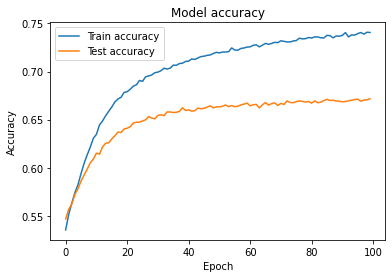

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')
plt.savefig('Q2(e)accuracy.png')

##Question 3
Find the optimal number of hidden neurons for first hidden layer of the 5-layer network (input
layer, 3 hidden layers, output layer) designed in Question 1 and 2.

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
hidden_layer_sizes = [64, 128, 256]


acc_and_loss_by_hidden_layer ={}

for hidden_layer in hidden_layer_sizes:
  fold_no = 1

  # Define per-fold score containers <-- these are new
  acc_per_fold = []
  loss_per_fold = []
  time_per_fold = []

  num_folds = 5

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # Merge inputs and targets
  inputs = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
  targets = np.concatenate((y_train, y_test), axis=0)

  for train, test in kfold.split(inputs, targets):

    ################### model code #################

    BATCH_SIZE = 512

    # define the 77-128-128-128-1 architecture using Keras
    model = Sequential()

    # input layer
    model.add(Dense(77, input_shape=(77,), activation="relu"))

    # three hidden layers of 128 neurons each with ReLU activation function
    # Apply dropout of probability 0.2 to each of the hidden layers.
    for i in range(3):
      model.add(Dense(hidden_layer, activation="relu"))
      model.add(Dropout(0.2))

    # an output layer with sigmoid activation function.
    model.add(Dense(1, activation="sigmoid"))

    # Use a mini-batch gradient descent with ‘adam’ optimizer with learning rate of 0.001, and batch size = 256. 
    opt = keras.optimizers.Adam(learning_rate=0.001)

    # Binary crossentropy is a loss function that is used in binary classification tasks.
    # These are tasks that answer a question with only two choices (yes or no, A or B, 0 or 1, left or right).
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    time_callback = TimeHistory()


    H = model.fit(inputs[train], 
                  targets[train], epochs=100, 
                  batch_size=BATCH_SIZE,
                  use_multiprocessing=True,
                  callbacks=[time_callback],
                  validation_data=(inputs[test], targets[test]),
                  verbose = 0)
    
    # Generate generalization metrics
    times = time_callback.times
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f"Size of hidden layer: {hidden_layer}")
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print(f'Time for fold {fold_no}: {times[-1]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    time_per_fold.append(times)

    # Increase fold number
    fold_no = fold_no + 1

  acc_and_loss_by_hidden_layer[hidden_layer] = {"ACC":acc_per_fold,
                                            "LOSS":loss_per_fold,
                                            "TIME":time_per_fold
                                            }


------------------------------------------------------------------------
Training for fold 1 ...
Size of hidden layer: 64
Score for fold 1: loss of 0.6246289014816284; accuracy of 64.80480432510376%
Time for fold 1: 0.9356129169464111
------------------------------------------------------------------------
Training for fold 2 ...
Size of hidden layer: 64
Score for fold 2: loss of 0.6290069818496704; accuracy of 64.64020013809204%
Time for fold 2: 0.9368853569030762
------------------------------------------------------------------------
Training for fold 3 ...
Size of hidden layer: 64
Score for fold 3: loss of 0.6221017241477966; accuracy of 64.68135118484497%
Time for fold 3: 0.9566876888275146
------------------------------------------------------------------------
Training for fold 4 ...
Size of hidden layer: 64
Score for fold 4: loss of 0.6238633990287781; accuracy of 64.69507217407227%
Time for fold 4: 0.9870269298553467
------------------------------------------------------------

a) Plot the mean cross-validation accuracies on the final epoch for different
numbers of hidden-layer neurons using a scatter plot. Limit the search space of the
number of neurons to {64, 128, 256}.

Continue using 5-fold cross validation on training dataset.

In [ ]:
hidden_layer_size_to_plt = []
mean_accuracies_to_plt =[]

for hidden_layer_sz, data in acc_and_loss_by_hidden_layer.items():
  hidden_layer_acc = data["ACC"]
  mean_fold_acc = sum(hidden_layer_acc)/len(hidden_layer_acc)

  hidden_layer_size_to_plt.append(hidden_layer_sz)
  mean_accuracies_to_plt.append(mean_fold_acc)


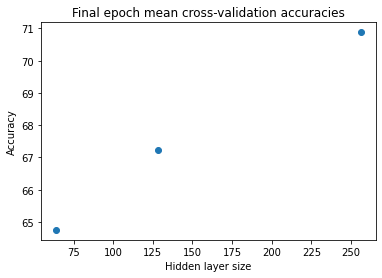

In [ ]:
plt.scatter(hidden_layer_size_to_plt,mean_accuracies_to_plt)
plt.title('Final epoch mean cross-validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Hidden layer size')
# plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')

plt.savefig('Q3(a)mean cross-validation accuracies.png')

b) Select the optimal number of neurons for the hidden layer. State the rationale
for your selection.


Hidden layer of 256, highest accuracy


In [ ]:
256


256

c) Plot the train and test accuracies against training epochs with the optimal
number of neurons using a line plot.

In [ ]:
BATCH_SIZE = 512
HIDDEN_LAYER_SIZE = 256

# define the 77-128-128-128-1 architecture using Keras
model = Sequential()

model.add(Dense(77, input_shape=(77,), activation="relu"))

for i in range(3):
  model.add(Dense(HIDDEN_LAYER_SIZE, activation="relu"))
  model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


H = model.fit(X_train_scaled, 
              y_train, epochs=100, 
              batch_size=BATCH_SIZE,
              use_multiprocessing=True,
              validation_data=(X_test_scaled, y_test),
              verbose = 2)

Epoch 1/100
250/250 - 2s - loss: 0.6882 - accuracy: 0.5399 - val_loss: 0.6839 - val_accuracy: 0.5538 - 2s/epoch - 10ms/step
Epoch 2/100
250/250 - 1s - loss: 0.6806 - accuracy: 0.5596 - val_loss: 0.6792 - val_accuracy: 0.5615 - 1s/epoch - 5ms/step
Epoch 3/100
250/250 - 1s - loss: 0.6738 - accuracy: 0.5737 - val_loss: 0.6736 - val_accuracy: 0.5739 - 948ms/epoch - 4ms/step
Epoch 4/100
250/250 - 1s - loss: 0.6654 - accuracy: 0.5901 - val_loss: 0.6677 - val_accuracy: 0.5811 - 949ms/epoch - 4ms/step
Epoch 5/100
250/250 - 1s - loss: 0.6558 - accuracy: 0.6042 - val_loss: 0.6615 - val_accuracy: 0.5949 - 935ms/epoch - 4ms/step
Epoch 6/100
250/250 - 1s - loss: 0.6452 - accuracy: 0.6174 - val_loss: 0.6531 - val_accuracy: 0.6049 - 1s/epoch - 4ms/step
Epoch 7/100
250/250 - 1s - loss: 0.6345 - accuracy: 0.6319 - val_loss: 0.6447 - val_accuracy: 0.6179 - 971ms/epoch - 4ms/step
Epoch 8/100
250/250 - 1s - loss: 0.6232 - accuracy: 0.6439 - val_loss: 0.6377 - val_accuracy: 0.6250 - 957ms/epoch - 4ms/step


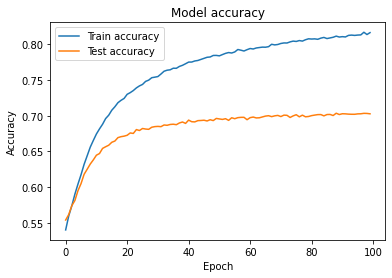

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')
plt.savefig('Q3c(b)accuracy.png')

d) How does dropouts work, and what is the purpose of dropouts?

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass.

e) Besides early stopping and dropout, what is another approach that you could
take to address overfitting in the model, and how does it work? Implement the
approach.

Note: use this optimal number of neurons for the rest of the experiments.

Regularization

##Question 4
In this section, we will understand the utility of such a neural network in real world scenarios.

a) Record yourself with a wav file using (https://voice-recorder-online.com/) for 5
seconds, either in a positive or a negative manner. Preprocess the data using the
provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.

b) Do a model prediction on your sample test dataset and obtain the predicted label
using a threshold of 0.5. The model used is the optimized pretrained model using the
selected optimal batch size and optimal number of neurons.

c) Find the most important features on the model prediction for your test sample
using SHAP. Plot the local feature importance with a force plot and explain your
observations. (Refer to the documentation and these three useful references:

https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,

https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,

https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)